## Deep neural network for ASD classification using resting-state fMRI

This notebook evaluate a deep neural network for ASD diagnosis using functionañ time series data from brain regions of interest. The used resting-state fMRI data from the ABIDE dataset were preprocessed by the **Preprocessed Connectome Project (PCP)** using four pipelines, involving 1100 subjects from multiple international sites.

### Configure the loading data

 The variables necessary for loading the neuroimaging data are defined. The `pipeline` and `atlas` used for preprocessing and ROIs extraction are specified. Additionally, list all neuroimaging sites available in the dataset and those that are to be included in the analysis are selected using the `sites` and `test_site` variables.

In [1]:
pipeline = 'fsl'  
rois = 'rois_aal'

# List of all available neuroimaging sites in the dataset
all_sites = [
    'caltech', 'cmu', 'kki', 'leuven_1', 'leuven_2', 'max_mun', 'nyu', 
    'ohsu', 'olin', 'pitt', 'sbl', 'sdsu', 'stanford', 'trinity', 
    'ucla_1', 'ucla_2', 'um_1', 'um_2', 'usm', 'yale'
]

# Sites include in the analysis
sites = all_sites

# Testing site
test_site = 'yale'

### ROIs data loading function

Definition of the `load_rois_data(pipeline, rois, sites)` function to retrieve subject time series and diagnostic labels from each neuroimaging site in `sites`. This function reads phenotypic information from CSV files, then loads the time series data for each subject. Also handle potential issues, such as missing files or NaN values, to ensure data integrity before analysis.

In [2]:
import os
import csv
import numpy as np


def load_rois_data(pipeline, rois, sites):
    """
    Loads time series and diagnostic labels from neuroimaging data files for the specified sites.
    
    Parameters:
        pipeline (str): Preprocessing pipeline used for the data.
        rois (str): Atlas defining regions of interest.
        sites (list of str): List of site names to load data from.

    Returns:
        rois_data (dict): Contains data for each subject.
        rois_labels (dict): Contains diagnostic labels for each site.
    """

    rois_data = {}  # Dictionary to store data for each subject
    rois_labels = {}  # Dictionary to store labels for each site

    for site in sites:
        # Define path for phenotypic data for the current site
        phenotypic_path = f"data/phenotypic_full/{site}/phenotypic.csv"

        try:
            with open(phenotypic_path, 'r') as file:
                reader = csv.DictReader(file)
                site_data = []  # List to store data for each subject at the site
                site_labels = []  # List to store labels for each subject at the site

                for row in reader:
                    file_id = row['file_id']  # Unique subject identifier
                    dx_group = row['dx_group']  # Diagnostic group (ASD=1, Control=0)
                    age = row['age'] # Age at the time of scan
                    sex = row['sex'] # Sex (Male=1, Female=2)

                    # Define path for the time series data file
                    data_file_path = os.path.join(f"data/{pipeline}/{rois}/{site}", f"{file_id}_{rois}.1D")

                    # Check if the data file exists
                    if not os.path.exists(data_file_path):
                        print(f"File Not Found Error: Data file not found at path {data_file_path}")
                        continue
                    
                    data = np.loadtxt(data_file_path)

                    # Check for NaN values and add time series to the site list
                    if np.isnan(data).any():
                        print(f"Value Error: NaN value found for subject {file_id}")
                    else:
                        site_data.append({'data':data, 'age': age, 'sex': sex})
                        site_labels.append(1 if dx_group == '1' else 0)  # Assign 1 for ASD, 0 for control

                # Store loaded data for the current site in the dictionaries
                rois_data[site] = site_data
                rois_labels[site] = np.array(site_labels)
                print(f"Loaded {len(site_data)} subjects from site {site}.")
                
        except FileNotFoundError:
            print(f"File Not Found Error: Phenotypic data not found for site {site}")

    return rois_data, rois_labels

Load data to be used in the analysis based on specified parameters.

In [3]:
rois_data, rois_labels = load_rois_data(pipeline, rois, sites)

File Not Found Error: Data file not found at path data/fsl/rois_aal/caltech\Caltech_0051458_rois_aal.1D
File Not Found Error: Data file not found at path data/fsl/rois_aal/caltech\Caltech_0051459_rois_aal.1D
File Not Found Error: Data file not found at path data/fsl/rois_aal/caltech\Caltech_0051460_rois_aal.1D
File Not Found Error: Data file not found at path data/fsl/rois_aal/caltech\Caltech_0051461_rois_aal.1D
File Not Found Error: Data file not found at path data/fsl/rois_aal/caltech\Caltech_0051462_rois_aal.1D
File Not Found Error: Data file not found at path data/fsl/rois_aal/caltech\Caltech_0051463_rois_aal.1D
File Not Found Error: Data file not found at path data/fsl/rois_aal/caltech\Caltech_0051464_rois_aal.1D
File Not Found Error: Data file not found at path data/fsl/rois_aal/caltech\Caltech_0051465_rois_aal.1D
File Not Found Error: Data file not found at path data/fsl/rois_aal/caltech\Caltech_0051466_rois_aal.1D
File Not Found Error: Data file not found at path data/fsl/rois_

### Compute metrics

In [38]:
def calculate_metrics(rois_data, rois_labels):
    """
    Calculate metrics for each site based on loaded ROIs data and labels.

    Parameters:
        rois_data (dict): Dictionary containing data for each site.
        rois_labels (dict): Dictionary containing diagnostic labels for each site.

    Returns:
        site_metrics (dict): Dictionary with metrics for each site.
    """
    site_metrics = {}

    for site in rois_data:
        # Ensure site data is not empty
        if site not in rois_labels or len(rois_data[site]) == 0:
            print(f"No data available for site: {site}")
            continue

        # Extract relevant information
        ages = [participant['age'] for participant in rois_data[site]]
        sexes = [participant['sex'] for participant in rois_data[site]]
        labels = rois_labels[site]  # 1 = TEA, 0 = Control

        # Convert age and sex to numeric
        ages = np.array([float(age) for age in ages])
        sexes = np.array([int(sex) for sex in sexes])

        # Separate metrics by diagnosis
        tea_indices = labels == 1
        control_indices = labels == 0

        # Calculate gender distribution
        males_tea = np.sum((sexes == 1) & tea_indices)
        females_tea = np.sum((sexes == 2) & tea_indices)
        males_control = np.sum((sexes == 1) & control_indices)
        females_control = np.sum((sexes == 2) & control_indices)

        # Calculate average age
        avg_age_tea = np.mean(ages[tea_indices]) if np.sum(tea_indices) > 0 else 0
        avg_age_control = np.mean(ages[control_indices]) if np.sum(control_indices) > 0 else 0
        avg_age = np.mean(ages)

        # Calculate totals
        total_tea = np.sum(labels)
        total_controls = len(labels) - total_tea
        total_cases = len(labels)

        # Store metrics
        site_metrics[site] = {
            'total_tea': total_tea,
            'total_controls': total_controls,
            'avg_age': avg_age,
            'avg_age_tea': avg_age_tea,
            'avg_age_control': avg_age_control,
            'males_tea': males_tea,
            'females_tea': females_tea,
            'males_control': males_control,
            'females_control': females_control,
            'total_cases': total_cases
        }

    return site_metrics

### Example use

In [39]:

# Example usage with your data
site_metrics = calculate_metrics(rois_data, rois_labels)

# Print metrics
for site, metrics in site_metrics.items():
    print(f"Site: {site}")
    print(f"  Total TEA: {metrics['total_tea']}")
    print(f"  Total Controls: {metrics['total_controls']}")
    print(f"  Average Age (All): {metrics['avg_age']:.2f}")
    print(f"  Average Age (TEA): {metrics['avg_age_tea']:.2f}")
    print(f"  Average Age (Control): {metrics['avg_age_control']:.2f}")
    print(f"  Males (TEA): {metrics['males_tea']}")
    print(f"  Females (TEA): {metrics['females_tea']}")
    print(f"  Males (Control): {metrics['males_control']}")
    print(f"  Females (Control): {metrics['females_control']}")
    print(f"  Total Cases: {metrics['total_cases']}")
    print()


Site: caltech
  Total TEA: 19
  Total Controls: 19
  Average Age (All): 28.16
  Average Age (TEA): 27.44
  Average Age (Control): 28.87
  Males (TEA): 15
  Females (TEA): 4
  Males (Control): 15
  Females (Control): 4
  Total Cases: 38

Site: cmu
  Total TEA: 14
  Total Controls: 13
  Average Age (All): 26.59
  Average Age (TEA): 26.36
  Average Age (Control): 26.85
  Males (TEA): 11
  Females (TEA): 3
  Males (Control): 10
  Females (Control): 3
  Total Cases: 27

Site: kki
  Total TEA: 22
  Total Controls: 33
  Average Age (All): 10.10
  Average Age (TEA): 10.01
  Average Age (Control): 10.16
  Males (TEA): 18
  Females (TEA): 4
  Males (Control): 24
  Females (Control): 9
  Total Cases: 55

Site: leuven_1
  Total TEA: 14
  Total Controls: 15
  Average Age (All): 22.59
  Average Age (TEA): 21.86
  Average Age (Control): 23.27
  Males (TEA): 14
  Females (TEA): 0
  Males (Control): 15
  Females (Control): 0
  Total Cases: 29

Site: leuven_2
  Total TEA: 15
  Total Controls: 20
  Avera

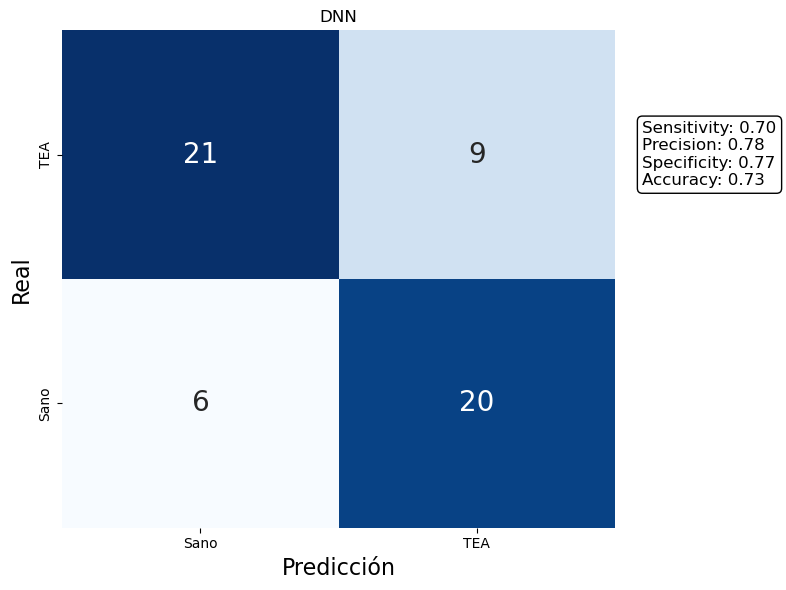

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(VP, VN, FP, FN):
    """
    Plot confusion matrix and display performance metrics.

    Parameters:
        VP (int): True Positives
        VN (int): True Negatives
        FP (int): False Positives
        FN (int): False Negatives
    """
    # Confusion matrix
    confusion_matrix = np.array([[VP, FN], [FP, VN]])

    # Calculate metrics
    sensitivity = VP / (VP + FN) if (VP + FN) > 0 else 0
    precision = VP / (VP + FP) if (VP + FP) > 0 else 0
    specificity = VN / (VN + FP) if (VN + FP) > 0 else 0
    accuracy = (VP + VN) / (VP + VN + FP + FN) if (VP + VN + FP + FN) > 0 else 0

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                annot_kws={"fontsize": 20},  # Increase font size for annotations
                xticklabels=["Sano", "TEA"],
                yticklabels=["TEA", "Sano"])
    plt.title("DNN")
    plt.xlabel("Predicción", fontsize=16)
    plt.ylabel("Real", fontsize=16)

    # Add metrics as text
    metrics_text = (f"Sensitivity: {sensitivity:.2f}\n"
                    f"Precision: {precision:.2f}\n"
                    f"Specificity: {specificity:.2f}\n"
                    f"Accuracy: {accuracy:.2f}")
    plt.text(2.1, 0.5, metrics_text, fontsize=12, va='center', ha='left', bbox=dict(boxstyle="round", edgecolor="black", facecolor="white"))

    plt.tight_layout()
    plt.show()

# Example usage
plot_confusion_matrix(VP=21, VN=20, FP=6, FN=9)